In [1]:
import numpy as np
from hipposlam.utils import read_pickle
from hipposlam.sequences import Sequences
from hipposlam.comput_utils import circular_gau_filter, divide_ignore, midedges, Arena
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
import os
import matplotlib as mpl
from matplotlib import cm
from tqdm import tqdm
from scipy.ndimage import gaussian_filter


In [3]:
debug_plot_tag = True
project_tag = 'Avoidance'
data_dir = join('data', project_tag)
plot_dir = join('plots', project_tag, 'BayesianDecoding')
os.makedirs(plot_dir, exist_ok=True)
trajdata = read_pickle(join(data_dir, 'traj.pickle'))
metadata = read_pickle(join(data_dir, 'meta.pickle'))
metadata['seqR'] = 5 # For now. Remove this line next time after seqR is stored in the metadata
metadata['seqL'] = 10 # For now. Remove this line next time after seqL is stored in the metadata
seqR = metadata['seqR']
seqL = metadata['seqL']
fkey2id_dict = metadata['stored_f']
id2fkey_dict = {val:key for key, val in fkey2id_dict.items()}
f_pos = metadata['fpos']
trajdf = pd.DataFrame(trajdata)
trajdf['X_Nrow'] = trajdf['X'].apply(lambda x : x.shape[0])
trajdf['a'] = trajdf['rota'] * trajdf['rotz']

In [4]:
# Occpancy ===========================
bodysd = 0.15  # body length of the robot = 0.3m
dp = 0.1
da = 2*np.pi/36
xmin = np.floor(trajdf['x'].min() * 10) / 10
xmax = np.ceil(trajdf['x'].max() * 10) / 10
ymin = np.floor(trajdf['y'].min() * 10) / 10
ymax = np.ceil(trajdf['y'].max() * 10) / 10
amin, amax = -np.pi, np.pi

BD = Arena(xmin, xmax, ymin, ymax, amin, amax, dp, da, bodysd)
occ, edges3d = BD.compute_histogram3d(trajdf['x'].to_numpy(), trajdf['y'].to_numpy(), trajdf['a'].to_numpy())
occ_p = occ.sum(axis=2)
occ_a = occ.sum(axis=0).sum(axis=0)
if debug_plot_tag:
    fig = plt.figure(figsize=(8, 4), facecolor='w')
    ax1 = fig.add_axes([0, 0, 0.4, 0.9])
    ax2 = fig.add_axes([0.6, 0, 0.3, 0.6], polar=True)
    cbar_ax = fig.add_axes([0.41, 0, 0.04, 0.9])
    im1 = ax1.pcolormesh(BD.xedges, BD.yedges, occ_p.T, cmap='hot')
    cb = fig.colorbar(im1, cax=cbar_ax)
    ax2.bar(BD.aedm, occ_a, width=da)
    fig.savefig(join(plot_dir, 'Occupancy'))


In [12]:
# Organize Spike Data ====================
Num_Fnodes = trajdf['X_Nrow'].max()
xdict = dict()
ydict = dict()
adict = dict()
fposdict = dict()
for i in range(trajdf.shape[0]):

    Xmat = trajdf['X'][i]
    x = trajdf['x'][i]
    y = trajdf['y'][i]
    a = trajdf['a'][i]

    if Xmat.shape[0] < 1:
        continue
    fnode_ids, sigma_ids = Sequences.X2sigma(Xmat, seqR, sigma_state=False)

    for fnode_id, sigma_id in zip(fnode_ids, sigma_ids):
        nodekey = id2fkey_dict[fnode_id]
        ensem_key = '%s-%d'%(nodekey, sigma_id)

        fposdict[ensem_key] = f_pos[nodekey.split('_')[0]]

        if ensem_key in xdict:
            xdict[ensem_key].append(x)
            ydict[ensem_key].append(y)
            adict[ensem_key].append(a)

        else:
            xdict[ensem_key] = [x]
            ydict[ensem_key] = [y]
            adict[ensem_key] = [a]


In [13]:
# Compute Rate Map =================
plot_ratemap = True
plot_dir_ratemap = join(plot_dir, 'ratemaps')
os.makedirs(plot_dir_ratemap, exist_ok=True)
print('Compute ratemaps')
print('Save at ', plot_dir_ratemap)
num_ensem = len(xdict.keys())
id2ensemkey = [ensem_key for ensem_key in xdict.keys()]
ensemkey2id = dict()
for i, ensem_key in enumerate(id2ensemkey):
    ensemkey2id[ensem_key] = i

all_ratemaps = np.zeros((num_ensem, BD.xedm.shape[0], BD.yedm.shape[0]))

for i in tqdm(range(num_ensem)):
    ensem_key = id2ensemkey[i]
    xsp = xdict[ensem_key]
    ysp = ydict[ensem_key]
    asp = adict[ensem_key]

    Hsp3d, _ = BD.compute_histogram3d(xsp, ysp, asp)
    ratemap_3d = BD.compute_ratemap(occ, Hsp3d)
    maptmp = gaussian_filter(ratemap_3d, sigma=BD.bodysd_ind, mode='constant', cval=0, axes=(0, 1))
    ratemap_3d_gau = circular_gau_filter(maptmp, a_ax=BD.aedm, kappa=4*np.pi)

    ratemap_pos = ratemap_3d_gau.mean(axis=2)
    ratemap_a = ratemap_3d_gau.mean(axis=0).mean(axis=0)
    if debug_plot_tag:

        fig, ax = plt.subplots(2, 2, figsize=(10, 8))
        ax[0, 0].pcolormesh(BD.xedges, BD.yedges, ratemap_pos.T, cmap='hot')
        ax[0, 0].quiver(xsp, ysp, np.cos(asp), np.sin(asp), color='b', alpha=0.5)
        ax[0, 0].set_title(ensem_key)
        ax[0, 1].plot(BD.aedm, ratemap_a)
        ax[1, 0].pcolormesh(BD.xedges, BD.yedges, ratemap_pos.T, cmap='hot')
        ax[1, 1].axis('off')

        fig.tight_layout()
        fig.savefig(join(plot_dir_ratemap, '%d.png'%(i)), dpi=200)
        plt.close(fig)
    break

Compute ratemaps
Save at  plots\Avoidance\ratemaps


  0%|          | 0/1960 [00:00<?, ?it/s]


TypeError: gaussian_filter() got an unexpected keyword argument 'axes'

In [15]:
import scipy
scipy.__version__

'1.10.1'

In [7]:
from scipy.special import factorial

def logPois(r, k, epsilon=1e-6):
    out = k * np.log(r+epsilon) - (r+epsilon) - factorial(k)
    return out

def PBern(p, k):
    return (p**k) * ((1-p) ** (1-k))

def logBern(p, k):
    out = k * np.log(p) + (1-k) * np.log(1-p)
    return out




In [13]:

xML = np.zeros(trajdf.shape[0])
yML = np.zeros(trajdf.shape[0])
np.random.seed(1)
subsampvec = np.random.permutation(num_ensem)

for i in tqdm(range(trajdf.shape[0])):
    f_sigma = trajdf['f_sigma'][i]
    idlist = []
    for nodekey, sigma_list in f_sigma.items():
        for sigma in sigma_list:
            ensem_key = '%s-%d'%(nodekey, sigma)
            ensem_id = ensemkey2id[ensem_key]
            idlist.append(ensem_id)

    act_vec = np.zeros(num_ensem)
    act_vec[idlist] = 1


    # all_ratemaps_epsilon = all_ratemaps + 1e-6
    # k_3d = act_vec.reshape(num_ensem, 1, 1)
    # logL_3d = k_3d * np.log(all_ratemaps_epsilon) - all_ratemaps_epsilon - factorial(k_3d)
    # logL = np.sum(logL_3d, axis=0)

    logL = np.zeros((BD.xedm.shape[0], BD.yedm.shape[0]))
    # for j in subsampvec[:200]:
    for j in range(num_ensem):
        ratemap = all_ratemaps[j]
        k = act_vec[j]
        ratemap_epsilon = ratemap + 1e-6
        out = k * np.log(ratemap_epsilon) - ratemap_epsilon - factorial(k)
        logL += out

    maxid1D_logL = np.argmax(logL)
    maxid2D_logL = np.unravel_index(maxid1D_logL, logL.shape)
    xML[i] = BD.xedm[maxid2D_logL[0]]
    yML[i] = BD.yedm[maxid2D_logL[1]]




100%|██████████| 15343/15343 [24:54<00:00, 10.27it/s]


0.13446254019992793


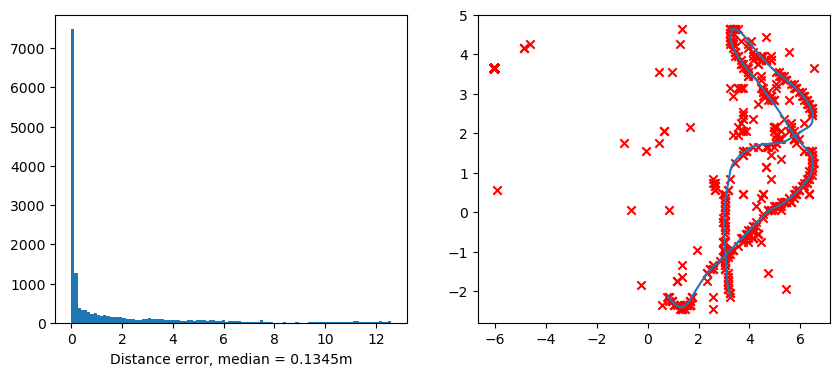

In [33]:
breakind=15342
xgt = trajdf['x'].to_numpy()[:breakind]
ygt = trajdf['y'].to_numpy()[:breakind]
xML = xML[:breakind]
yML = yML[:breakind]
mse = np.sqrt((xML - xgt)**2 + (yML - ygt)**2)
print(np.median(mse))
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(mse, bins=100)

breakind1 = 10000
ax[0].set_xlabel('Distance error, median = %0.4fm'  %np.median(mse))
ax[1].plot(xgt[breakind1:breakind1 + 500], ygt[breakind1:breakind1 + 500])
ax[1].scatter(xML[breakind1:breakind1 + 500], yML[breakind1:breakind1 + 500], color='r', marker='x')

In [57]:
type(all_ratemaps)

# Boundary Effect Investigation

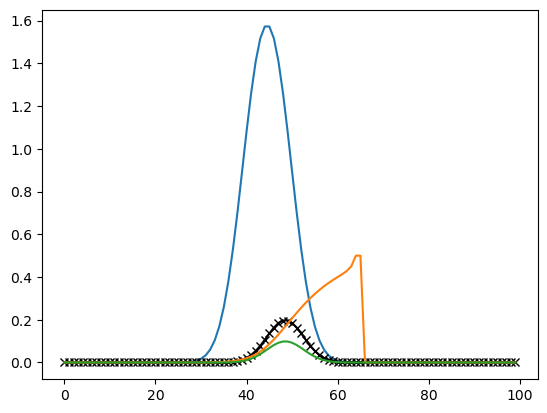

In [62]:
from scipy.ndimage import gaussian_filter1d


foox = np.zeros(100)
foox1 = foox.copy()
foox1[40:50] = 2
foox2 = foox.copy()
foox2[48:50] = 1
foox3 = divide_ignore(foox2, foox1)


foosd = 4

foo1 = gaussian_filter1d(foox1, sigma=foosd)
foo2 = gaussian_filter1d(foox2, sigma=foosd)
foo3 = divide_ignore(foo2, foo1)
plt.plot(foo1)
plt.plot(foo2, marker='x', color='k')
plt.plot(foo3)
plt.plot(gaussian_filter1d(foox3, sigma=foosd))


1.0


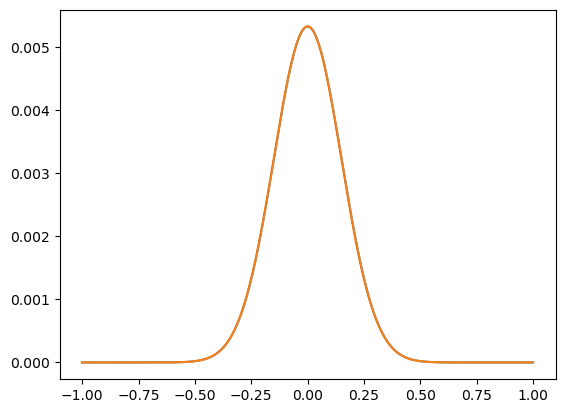

In [75]:

fiox = np.linspace(-1, 1, 1000)
fiodx = fiox[1]- fiox[0]

fiosd = 0.15
fioy = np.exp(np.square(fiox/fiosd) / -2) / (fiosd * np.sqrt(2*np.pi))
plt.plot(fiox, fioy * fiodx)


fiosd_ind = fiosd/fiodx
fiox_ind = np.zeros(fiox.shape[0])
fiox_ind[500] = 1
fioy_gau = gaussian_filter1d(fiox_ind, sigma=fiosd_ind)
plt.plot(fiox, fioy_gau)
print(fioy_gau.sum())


In [74]:
fiodx

0.002002002002001957